In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import glob
from scipy.interpolate import interp1d

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
## for running on colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data_dir = "rto_data"
data_files = glob.glob(f"{data_dir}/ercot_hourly_demand_and_price_*.csv")

years = [ii[-8:-4] for ii in data_files]

dataframes = {}
august_dataframes = {}

for year, file_path in zip(years,data_files):
    dataframes[year] = pd.read_csv(file_path)
    dataframes[year]['timestamp'] = pd.to_datetime(dataframes[year]['timestamp'], utc=True, errors='coerce').dt.tz_convert('US/Central')
    august_dataframes[year] = dataframes[year][dataframes[year]['timestamp'].dt.month == 8].copy()

avg_data_by_hour = {}

for year, df in august_dataframes.items():
    df['hour'] = df['timestamp'].dt.hour
    # Ensure 'load.load' is numeric before grouping
    df['load'] = pd.to_numeric(df['load'], errors='coerce')
    x1 = df.groupby('hour')[['load', 'net_load', 'fuel_mix.natural_gas', 'fuel_mix.solar', 'fuel_mix.wind', 'fuel_mix.power_storage', 'price']].mean().reset_index()

    ## define net_load to be total load minus solar, wind, and batteries
    x1['net_load'] = x1['load'] - x1['fuel_mix.solar'] - x1['fuel_mix.wind']- x1['fuel_mix.power_storage']
    x1 = x1.set_index('hour')
    avg_data_by_hour[year] = x1

    print(f"Average data by hour in August {year}:")
    display(avg_data_by_hour[year].head())

Average data by hour in August 2018:


,load,net_load,fuel_mix.natural_gas,fuel_mix.solar,fuel_mix.wind,fuel_mix.power_storage,price
hour,,,,,,,
0,44758.876344,34922.844659,19432.146425,0.0,9836.031685,0.0,19.951290
1,42617.206989,32996.020463,18133.536863,0.0,9621.186526,0.0,18.689032
2,41150.545699,31919.306820,17415.758017,0.0,9231.238879,0.0,17.885484
3,40385.422043,31527.757464,17111.066429,0.0,8857.664579,0.0,17.182903
4,40555.620968,32103.918636,17191.296571,0.0,8451.702332,0.0,17.271935


Average data by hour in August 2024:


,load,net_load,fuel_mix.natural_gas,fuel_mix.solar,fuel_mix.wind,fuel_mix.power_storage,price
hour,,,,,,,
0,60091.381720,43892.044624,31463.061559,0.551075,16116.800269,81.985753,20.048065
1,57336.658602,41953.216935,30057.857796,0.365860,15324.103226,58.972581,18.150000
2,55213.024194,40759.110753,29110.170968,0.361559,14400.705108,52.846774,16.955484
3,53749.314516,40358.026613,28849.690860,0.335215,13338.415323,52.537366,16.671935
4,52978.620968,40661.483602,29134.357258,0.325269,12254.664516,62.147581,16.989355


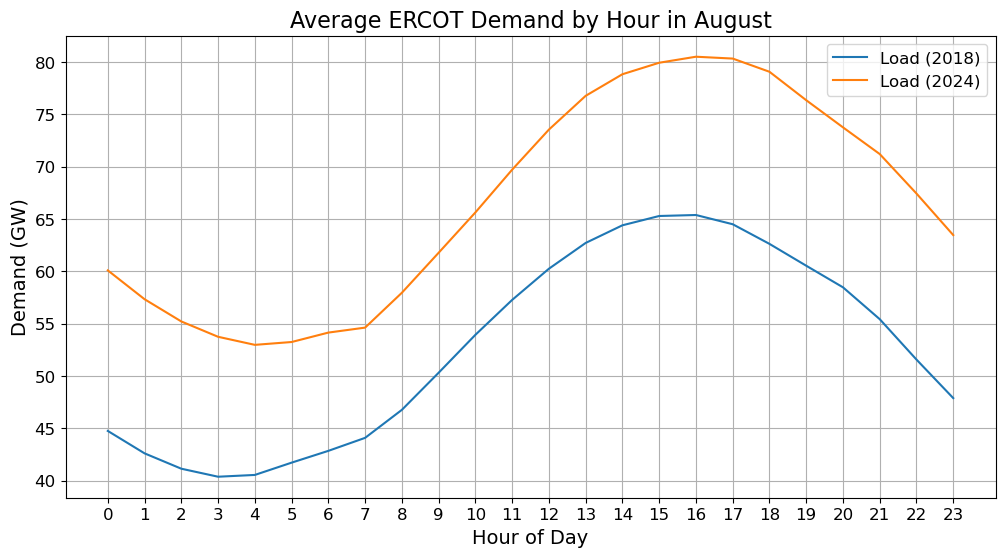

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for year, df in avg_data_by_hour.items():
    if year == '2023': continue
    # Create a new variable for load data in GW
    load_gw = df['load'] / 1e3
    sns.lineplot(data=df, x='hour', y=load_gw, label=f'Load ({year})')

plt.title('Average ERCOT Demand by Hour in August', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Demand (GW)', fontsize=14)
plt.xticks(range(0, 24))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.savefig('ercot_demand_by_hour_august.png', dpi=300)
plt.show()

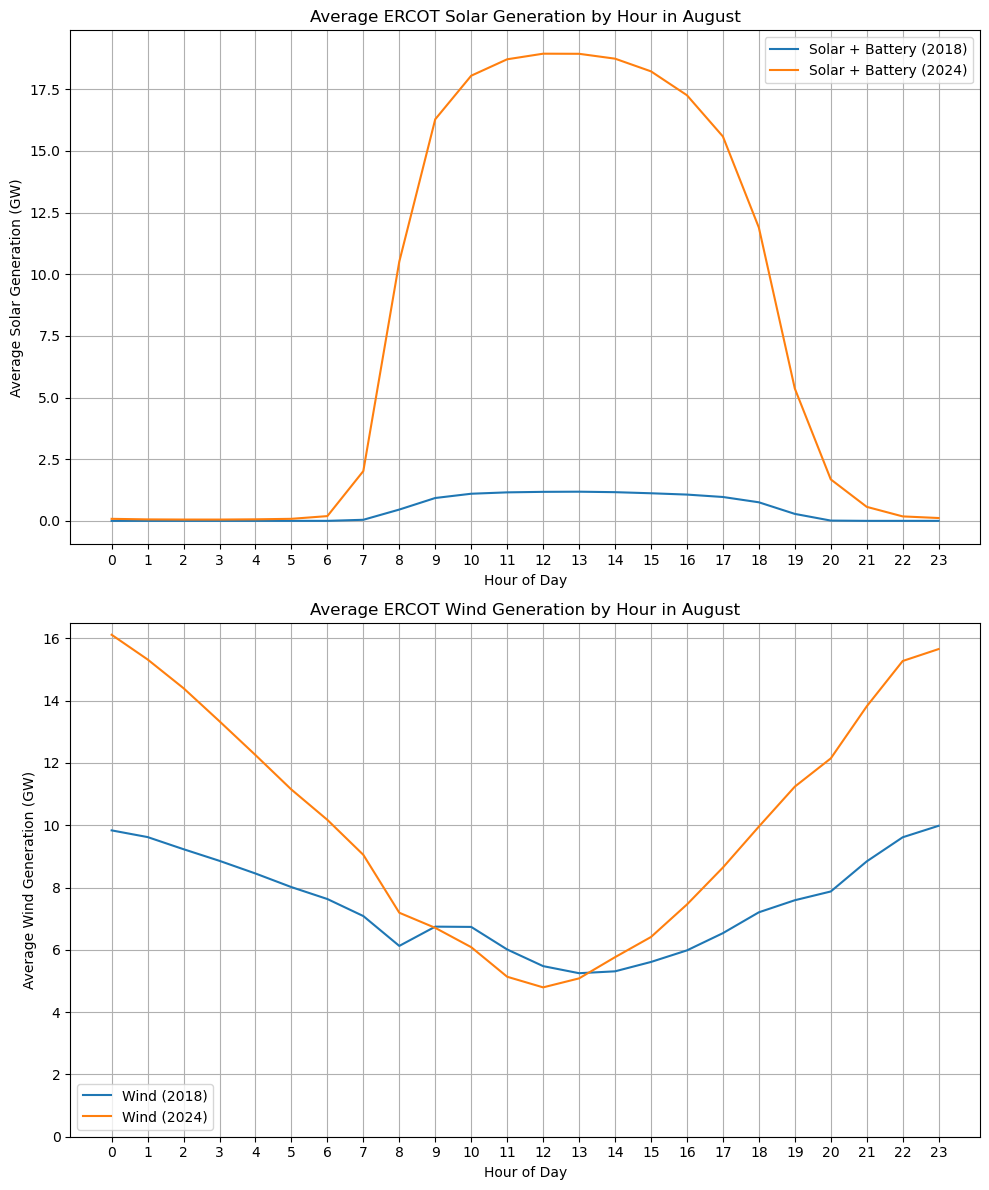

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Solar panel (left)
for year, df in avg_data_by_hour.items():
    if year in ['2018', '2024']:
        x1 = (df['fuel_mix.solar']+df['fuel_mix.power_storage'])/1e3
        ax1.plot(df.index, x1, label=f'Solar + Battery ({year})')

ax1.set_title('Average ERCOT Solar Generation by Hour in August')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Solar Generation (GW)')
ax1.set_xticks(range(0, 24))
ax1.grid(True)
ax1.legend()

# Wind panel (right)
for year, df in avg_data_by_hour.items():
    if year in ['2018', '2024']:
        wind_gw = df['fuel_mix.wind'] / 1e3
        ax2.plot(df.index, wind_gw, label=f'Wind ({year})')

ax2.set_title('Average ERCOT Wind Generation by Hour in August')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Wind Generation (GW)')
ax2.set_xticks(range(0, 24))
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, 16.5)

plt.tight_layout()
plt.savefig('ercot_solar_wind_generation_august.png', dpi=300)
plt.show()

In [6]:
# average solar generation in august during the peak hour
for year, df in avg_data_by_hour.items():
    if year in ['2018', '2024']:
        x1 = df['fuel_mix.solar'].max()/1e3
        print(year, x1)

2018 1.1822690032258063
2024 18.784636290322577


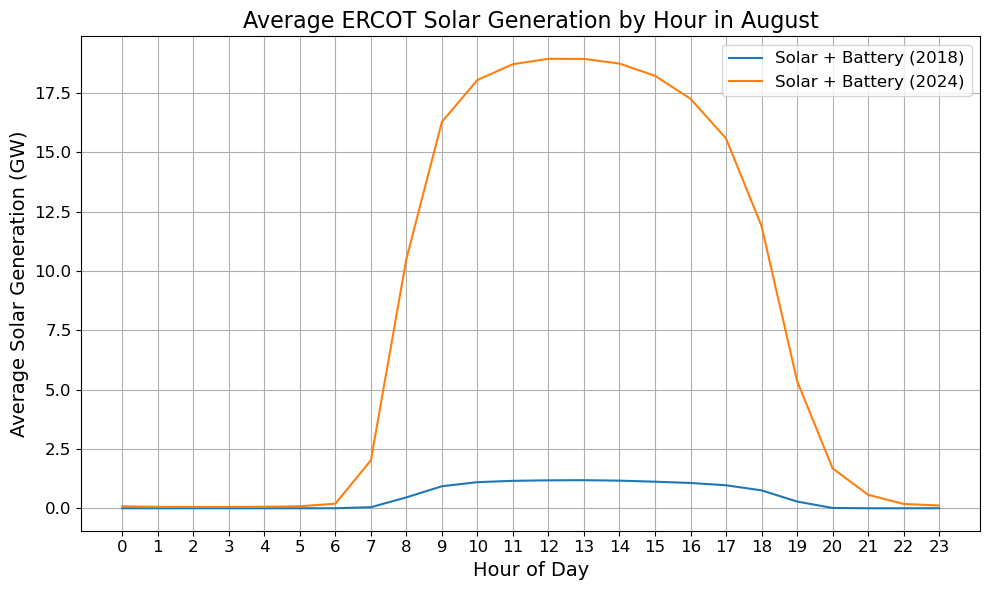

In [7]:
fig, ax1= plt.subplots(1, 1, figsize=(10, 6))

# Solar panel
for year, df in avg_data_by_hour.items():
    if year in ['2018', '2024']:
        x1 = (df['fuel_mix.solar']+df['fuel_mix.power_storage'])/1e3
        ax1.plot(df.index, x1, label=f'Solar + Battery ({year})')

ax1.set_title('Average ERCOT Solar Generation by Hour in August', fontsize=16)
ax1.set_xlabel('Hour of Day', fontsize=14)
ax1.set_ylabel('Average Solar Generation (GW)', fontsize=14)
ax1.set_xticks(range(0, 24))
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True)
ax1.legend(fontsize=12)

plt.tight_layout()
plt.savefig('ercot_solar_generation_august.png', dpi=300)
plt.show()

/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_19816/4171062488.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()
/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_19816/4171062488.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()


Price at 52.41 GW net load for 2018: $33.38/MWh
Price at 42.18 GW net load for 2018: $23.83/MWh
Price at 52.41 GW net load for 2024: $29.48/MWh
Price at 42.18 GW net load for 2024: $17.65/MWh


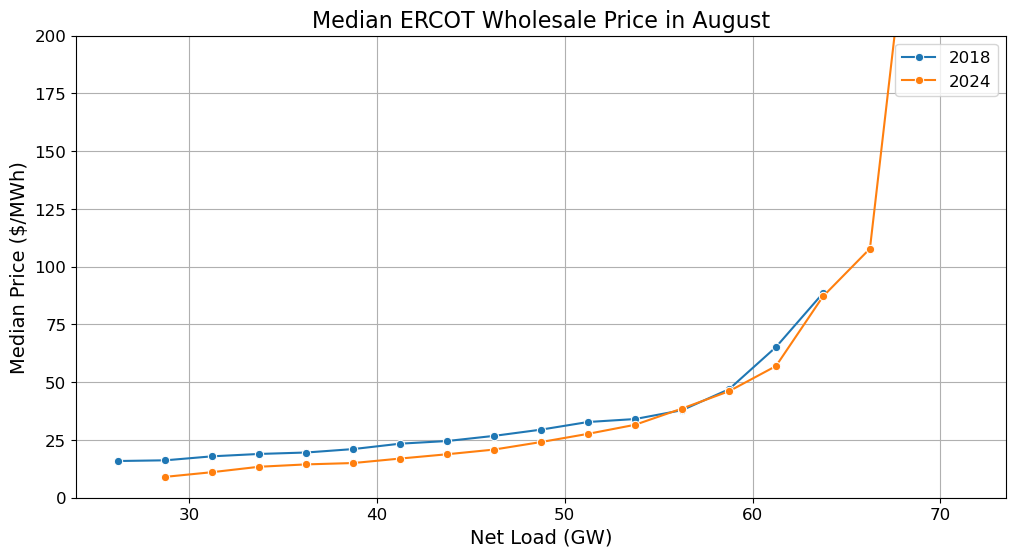

In [8]:
# Define the bin edges based on the range of net_load across all years
all_net_load = pd.concat([df['net_load'] for df in august_dataframes.values()])
min_net_load = all_net_load.min()
max_net_load = all_net_load.max()
bin_width = 2500
bins = np.arange(min_net_load - (min_net_load % bin_width), max_net_load + bin_width, bin_width)

plt.figure(figsize=(12, 6))

years = ['2018', '2024']

for year in years:
    df = august_dataframes[year].copy() # Use a copy to avoid modifying the original dataframe

    # Create bins for net_load and calculate the median spp for each bin
    df['net_load_bin'] = pd.cut(df['net_load'], bins=bins, right=False)
    median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()

    # Get the midpoint of each bin for plotting
    median_spp_by_bin['net_load_midpoint'] = median_spp_by_bin['net_load_bin'].apply(lambda x: x.mid/1e3)

    # Create interpolation function to get prices at specific net load values
    interp_func = interp1d(median_spp_by_bin['net_load_midpoint'], 
                          median_spp_by_bin['price'], 
                          kind='linear', fill_value='extrapolate')
    
    # Print prices at specified net load values
    price_at_52_41 = interp_func(52.41)
    price_at_42_18 = interp_func(42.18)
    print(f"Price at 52.41 GW net load for {year}: ${price_at_52_41:.2f}/MWh")
    print(f"Price at 42.18 GW net load for {year}: ${price_at_42_18:.2f}/MWh")

    # Plot the median spp against the net load bin midpoints
    sns.lineplot(data=median_spp_by_bin, x='net_load_midpoint', y='price', marker='o', label=f'{year}')

plt.title('Median ERCOT Wholesale Price in August', fontsize=16)
plt.xlabel('Net Load (GW)', fontsize=14)
plt.ylabel('Median Price ($/MWh)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.ylim(0,200)
plt.savefig('ercot_price_vs_net_load_august.png', dpi=300)
plt.show()

In [10]:
print('2018', august_dataframes['2018']['fuel_mix.solar'].mean()/1e3)
print('2024', august_dataframes['2024']['fuel_mix.solar'].mean()/1e3)

2018 0.4751528591572581
2024 7.770779110663082


Cost at 60 GW total demand for 2018: $33.50/MWh
Cost at 60 GW total demand for 2024: $17.12/MWh


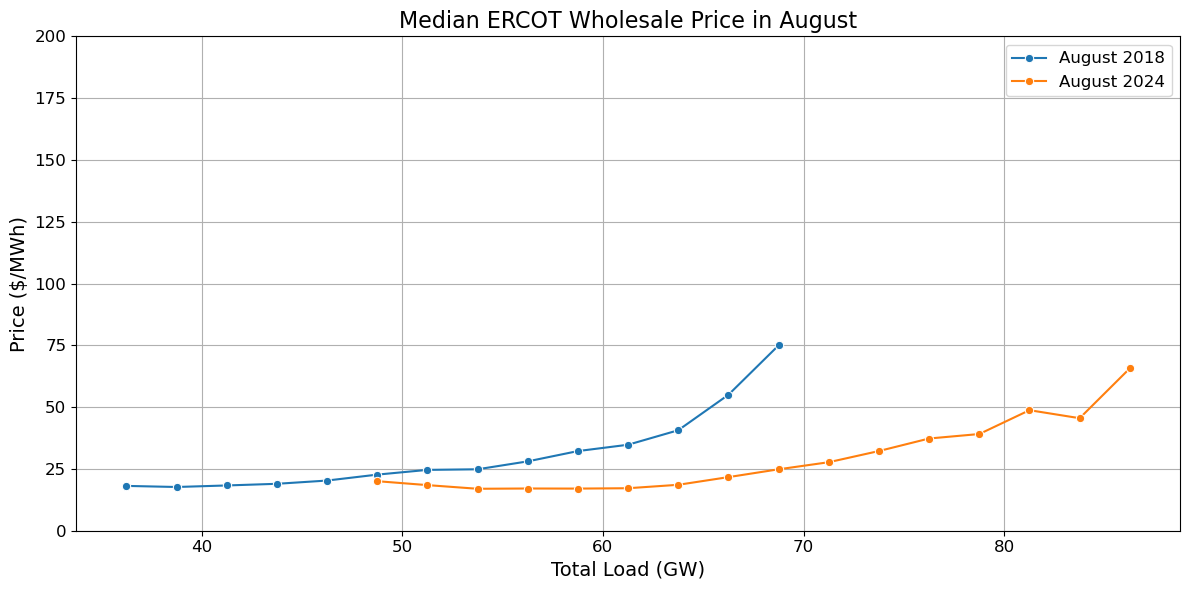

In [11]:
# Define the bin edges based on the range of total load across all years for consistent bins
all_total_load = pd.concat([df['load'] for df in august_dataframes.values()])
min_total_load = all_total_load.min()
max_total_load = all_total_load.max()
bin_width = 2500
bins = np.arange(min_total_load - (min_total_load % bin_width), max_total_load + bin_width, bin_width)

plt.figure(figsize=(12, 6)) # Use a single figure and axes

years = ['2018', '2024']

# Determine the overall x-axis range
total_load_min_overall = all_total_load.min()/1e3
total_load_max_overall = all_total_load.max()/1e3

for year in years:
    df = august_dataframes[year].copy() # Use a copy to avoid modifying the original dataframe

    df['total_load_bin'] = pd.cut(df['load'], bins=bins, right=False)
    mean_spp_by_total_load_bin = df.groupby('total_load_bin', observed=True)['price'].median().reset_index()
    mean_spp_by_total_load_bin['total_load_midpoint'] = mean_spp_by_total_load_bin['total_load_bin'].apply(lambda x: x.mid/1e3)

    # Create interpolation function
    interp_func = interp1d(mean_spp_by_total_load_bin['total_load_midpoint'], 
                          mean_spp_by_total_load_bin['price'], 
                          kind='linear', fill_value='extrapolate')
    
    # Interpolate cost at 60 GW
    cost_at_60gw = interp_func(60.0)
    print(f"Cost at 60 GW total demand for {year}: ${cost_at_60gw:.2f}/MWh")
    
    sns.lineplot(data=mean_spp_by_total_load_bin, x='total_load_midpoint', y='price', marker='o', label=f'August {year}') # Plot median lines


plt.title('Median ERCOT Wholesale Price in August', fontsize=16)
plt.xlabel('Total Load (GW)', fontsize=14)
plt.ylabel('Price ($/MWh)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.ylim(0, 200)

plt.tight_layout()
plt.savefig('ercot_price_vs_total_load_august.png', dpi=300)
plt.show()

Net load at 60 GW total demand for 2018: 52.41 GW
Net load at 60 GW total demand for 2024: 42.18 GW


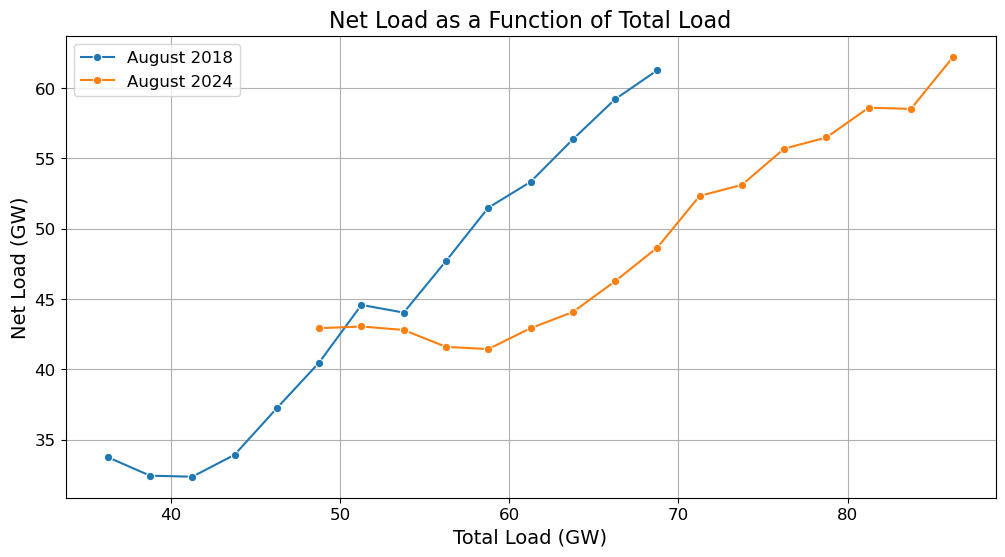

In [12]:
plt.figure(figsize=(12, 6))

years = ['2018', '2024']

# Define the bin edges based on the range of total load across all years for consistent bins
all_total_load = pd.concat([df['load'] for df in august_dataframes.values()])
min_total_load = all_total_load.min()
max_total_load = all_total_load.max()
bin_width = 2500
bins = np.arange(min_total_load - (min_total_load % bin_width), max_total_load + bin_width, bin_width)

for year in years:
    df = august_dataframes[year].copy()
    # Calculate the fraction of net load to total load
    df['net_load_fraction'] = df['net_load']/1e3
    # sns.scatterplot(data=df, x='load.load', y='net_load_fraction', alpha=0.5, label=f'{year} (Hourly Data)')

    # Create bins for total load and calculate the median net_load_fraction for each bin
    df['total_load_bin'] = pd.cut(df['load'], bins=bins, right=False)
    median_fraction_by_bin = df.groupby('total_load_bin', observed=True)['net_load_fraction'].median().reset_index()

    # Get the midpoint of each bin for plotting
    median_fraction_by_bin['total_load_midpoint'] = median_fraction_by_bin['total_load_bin'].apply(lambda x: x.mid/1e3)

    # Create interpolation function
    interp_func = interp1d(median_fraction_by_bin['total_load_midpoint'], 
                          median_fraction_by_bin['net_load_fraction'], 
                          kind='linear', fill_value='extrapolate')
    
    # Interpolate net load at 60 GW
    net_load_at_60gw = interp_func(60.0)
    print(f"Net load at 60 GW total demand for {year}: {net_load_at_60gw:.2f} GW")

    # Plot the median fraction against the total load bin midpoints
    sns.lineplot(data=median_fraction_by_bin, x='total_load_midpoint', y='net_load_fraction', marker='o', label=f'August {year}')


plt.title('Net Load as a Function of Total Load', fontsize=16)
plt.xlabel('Total Load (GW)', fontsize=14)
plt.ylabel('Net Load (GW)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.savefig('ercot_net_load_vs_total_load_august.png', dpi=300)
plt.show()

In [13]:
# Calculate demand-weighted average wholesale price for 2024
# Using 2024 hourly load data and the median price-load relationship

# Get 2024 data
df_2024 = august_dataframes['2024'].copy()

# Create the price-load relationship using the same binning approach as Cell 10
all_total_load = pd.concat([df['load'] for df in august_dataframes.values()])
min_total_load = all_total_load.min()
max_total_load = all_total_load.max()
bin_width = 2500
bins = np.arange(min_total_load - (min_total_load % bin_width), max_total_load + bin_width, bin_width)

# Create bins and get median price for each total load bin (2024 data)
df_2024['total_load_bin'] = pd.cut(df_2024['load'], bins=bins, right=False)
median_price_by_load_bin = df_2024.groupby('total_load_bin', observed=True)['price'].median().reset_index()
median_price_by_load_bin['total_load_midpoint'] = median_price_by_load_bin['total_load_bin'].apply(lambda x: x.mid)

# Create interpolation function for 2024 price-load relationship
interp_func_2024 = interp1d(median_price_by_load_bin['total_load_midpoint'], 
                           median_price_by_load_bin['price'], 
                           kind='linear', fill_value='extrapolate')

# Calculate predicted price for each hour based on the load
df_2024['predicted_price'] = interp_func_2024(df_2024['load'])

# Calculate demand-weighted average price
# This is sum(load_i * price_i) / sum(load_i)
total_load_weighted_price = (df_2024['load'] * df_2024['predicted_price']).sum()
total_load = df_2024['load'].sum()
demand_weighted_avg_price = total_load_weighted_price / total_load

print(f"2024 August Analysis:")
print(f"Total Load: {total_load/1e6:.2f} TWh")
print(f"Simple Average Price: ${df_2024['predicted_price'].mean():.2f}/MWh")
print(f"Demand-Weighted Average Price: ${demand_weighted_avg_price:.2f}/MWh")
print(f"Actual Average Price: ${df_2024['price'].mean():.2f}/MWh")

# Show some statistics
print(f"\nLoad Statistics (GW):")
print(f"Min Load: {df_2024['load'].min()/1e3:.1f} GW")
print(f"Max Load: {df_2024['load'].max()/1e3:.1f} GW")
print(f"Average Load: {df_2024['load'].mean()/1e3:.1f} GW")

2024 August Analysis:
Total Load: 49.52 TWh
Simple Average Price: $27.04/MWh
Demand-Weighted Average Price: $28.70/MWh
Actual Average Price: $35.84/MWh

Load Statistics (GW):
Min Load: 48.7 GW
Max Load: 85.5 GW
Average Load: 66.6 GW


In [14]:
# Calculate demand-weighted average wholesale price for 2024 using 2018 price-demand relationship
# Handle two scenarios for demand higher than 2018 data range

# Get 2018 and 2024 data
df_2018 = august_dataframes['2018'].copy()
df_2024 = august_dataframes['2024'].copy()

# Create the 2018 price-load relationship using the same binning approach
all_total_load = pd.concat([df['load'] for df in august_dataframes.values()])
min_total_load = all_total_load.min()
max_total_load = all_total_load.max()
bin_width = 2500
bins = np.arange(min_total_load - (min_total_load % bin_width), max_total_load + bin_width, bin_width)

# Create bins and get median price for each total load bin (2018 data)
df_2018['total_load_bin'] = pd.cut(df_2018['load'], bins=bins, right=False)
median_price_by_load_bin_2018 = df_2018.groupby('total_load_bin', observed=True)['price'].median().reset_index()
median_price_by_load_bin_2018['total_load_midpoint'] = median_price_by_load_bin_2018['total_load_bin'].apply(lambda x: x.mid)

# Remove any NaN values and sort by load
median_price_by_load_bin_2018 = median_price_by_load_bin_2018.dropna().sort_values('total_load_midpoint')

print(f"2018 data range: {df_2018['load'].min()/1e3:.1f} - {df_2018['load'].max()/1e3:.1f} GW")
print(f"2024 data range: {df_2024['load'].min()/1e3:.1f} - {df_2024['load'].max()/1e3:.1f} GW")
print(f"2018 binned data range: {median_price_by_load_bin_2018['total_load_midpoint'].min()/1e3:.1f} - {median_price_by_load_bin_2018['total_load_midpoint'].max()/1e3:.1f} GW")

# Find the maximum load and corresponding price in 2018 binned data
max_2018_load = median_price_by_load_bin_2018['total_load_midpoint'].max()
max_2018_price = median_price_by_load_bin_2018.loc[median_price_by_load_bin_2018['total_load_midpoint'] == max_2018_load, 'price'].iloc[0]

print(f"Highest 2018 bin: {max_2018_load/1e3:.1f} GW at ${max_2018_price:.2f}/MWh")

# Scenario 1: Cap at highest 2018 price for loads above 2018 range
interp_func_2018_capped = interp1d(median_price_by_load_bin_2018['total_load_midpoint'], 
                                  median_price_by_load_bin_2018['price'], 
                                  kind='linear', 
                                  bounds_error=False, 
                                  fill_value=(median_price_by_load_bin_2018['price'].iloc[0], max_2018_price))

# Scenario 2: Linear extrapolation for loads above 2018 range
interp_func_2018_extrapolated = interp1d(median_price_by_load_bin_2018['total_load_midpoint'], 
                                         median_price_by_load_bin_2018['price'], 
                                         kind='linear', 
                                         fill_value='extrapolate')

# Apply both scenarios to 2024 data
df_2024['predicted_price_capped'] = interp_func_2018_capped(df_2024['load'])
df_2024['predicted_price_extrapolated'] = interp_func_2018_extrapolated(df_2024['load'])

# Calculate demand-weighted average prices for both scenarios
# Scenario 1: Capped
total_load_weighted_price_capped = (df_2024['load'] * df_2024['predicted_price_capped']).sum()
total_load = df_2024['load'].sum()
demand_weighted_avg_price_capped = total_load_weighted_price_capped / total_load

# Scenario 2: Extrapolated
total_load_weighted_price_extrapolated = (df_2024['load'] * df_2024['predicted_price_extrapolated']).sum()
demand_weighted_avg_price_extrapolated = total_load_weighted_price_extrapolated / total_load

print(f"\n=== 2024 Analysis using 2018 Price-Demand Relationship ===")
print(f"Scenario 1 (Capped at highest 2018 price):")
print(f"  Simple Average Price: ${df_2024['predicted_price_capped'].mean():.2f}/MWh")
print(f"  Demand-Weighted Average Price: ${demand_weighted_avg_price_capped:.2f}/MWh")

print(f"\nScenario 2 (Linear extrapolation):")
print(f"  Simple Average Price: ${df_2024['predicted_price_extrapolated'].mean():.2f}/MWh")
print(f"  Demand-Weighted Average Price: ${demand_weighted_avg_price_extrapolated:.2f}/MWh")

print(f"\nFor comparison:")
print(f"  2024 Actual Average Price: ${df_2024['price'].mean():.2f}/MWh")
print(f"  2018 Actual Average Price: ${df_2018['price'].mean():.2f}/MWh")

# Show how many hours exceed the 2018 range
hours_above_2018_max = (df_2024['load'] > max_2018_load).sum()
total_hours = len(df_2024)
print(f"\nHours in 2024 with load above highest 2018 bin: {hours_above_2018_max}/{total_hours} ({100*hours_above_2018_max/total_hours:.1f}%)")

# Show price statistics for the extrapolated scenario
print(f"\nPrice range differences:")
print(f"  Capped scenario: ${df_2024['predicted_price_capped'].min():.2f} - ${df_2024['predicted_price_capped'].max():.2f}/MWh")
print(f"  Extrapolated scenario: ${df_2024['predicted_price_extrapolated'].min():.2f} - ${df_2024['predicted_price_extrapolated'].max():.2f}/MWh")


2018 data range: 36.0 - 69.8 GW
2024 data range: 48.7 - 85.5 GW
2018 binned data range: 36.2 - 68.8 GW
Highest 2018 bin: 68.8 GW at $74.98/MWh

=== 2024 Analysis using 2018 Price-Demand Relationship ===
Scenario 1 (Capped at highest 2018 price):
  Simple Average Price: $52.47/MWh
  Demand-Weighted Average Price: $55.77/MWh

Scenario 2 (Linear extrapolation):
  Simple Average Price: $81.64/MWh
  Demand-Weighted Average Price: $90.67/MWh

For comparison:
  2024 Actual Average Price: $35.84/MWh
  2018 Actual Average Price: $31.69/MWh

Hours in 2024 with load above highest 2018 bin: 327/744 (44.0%)

Price range differences:
  Capped scenario: $22.63 - $74.98/MWh
  Extrapolated scenario: $22.63 - $209.03/MWh


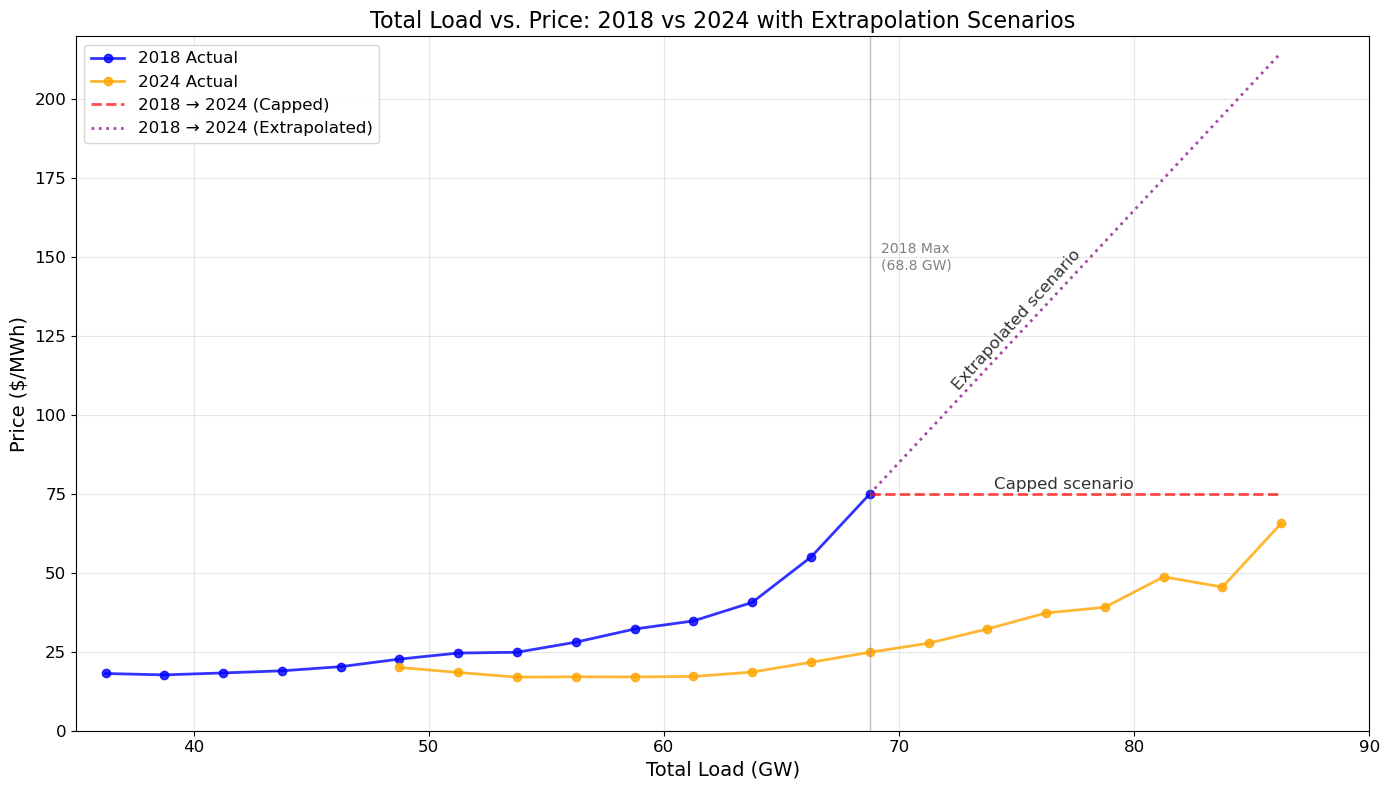

In [17]:
# Create visualization showing total load vs. price with extrapolation scenarios
plt.figure(figsize=(14, 8))

# Plot the original 2018 and 2024 median price-load relationships
years = ['2018', '2024']
colors = {'2018': 'blue', '2024': 'orange'}
median_price_data = {}
interp_funcs = {}

for year in years:
    df = august_dataframes[year].copy()
    
    # Create bins and get median price for each total load bin
    df['total_load_bin'] = pd.cut(df['load'], bins=bins, right=False)
    median_price_by_bin = df.groupby('total_load_bin', observed=True)['price'].median().reset_index()
    median_price_by_bin['total_load_midpoint'] = median_price_by_bin['total_load_bin'].apply(lambda x: x.mid)
    median_price_by_bin = median_price_by_bin.dropna().sort_values('total_load_midpoint')
    if year == '2024': 
        max_2024_load = median_price_by_bin['total_load_midpoint'].max()
        min_2024_load = median_price_by_bin['total_load_midpoint'].min()
    
    # Store data for later use
    median_price_data[year] = median_price_by_bin
    
    # Create interpolation function for fill areas
    interp_funcs[year] = interp1d(median_price_by_bin['total_load_midpoint'], 
                                  median_price_by_bin['price'], 
                                  kind='linear', 
                                  bounds_error=False, 
                                  fill_value='extrapolate')
    
    # Plot the actual data
    plt.plot(median_price_by_bin['total_load_midpoint'].astype(float)/1e3, median_price_by_bin['price'], 
             'o-', color=colors[year], linewidth=2, markersize=6, 
             label=f'{year} Actual', alpha=0.8)

# Create extended load range for extrapolation visualization
extended_load_range = np.linspace(max_2018_load/1e3, max_2024_load/1e3, 200) * 1e3  
overlap_load_range = np.linspace(min_2024_load/1e3, max_2018_load/1e3, 200) * 1e3  

# Calculate prices using both extrapolation scenarios
prices_capped = interp_func_2018_capped(extended_load_range)
prices_extrapolated = interp_func_2018_extrapolated(extended_load_range)

# Calculate prices for fill areas using stored interpolation functions
prices_2024_extended = interp_funcs['2024'](extended_load_range)
prices_2018_extended = interp_funcs['2018'](extended_load_range)

# Find the maximum load in 2024 binned data to limit fill areas
max_2024_load = median_price_data['2024']['total_load_midpoint'].max()
min_2024_load = median_price_data['2024']['total_load_midpoint'].min()

# Fill areas (limited to 2024 data range)
# Light pink: between orange (2024) and blue (2018), and between orange (2024) and red dashed (capped)
# plt.fill_between(extended_load_range/1e3, prices_capped, prices_2018_extended, 
#                 alpha=0.3, color='lightblue')
# plt.fill_between(extended_load_range/1e3, prices_2024_extended, prices_capped, 
#                 alpha=0.3, color='lightpink')

# # Additional light pink: between orange (2024) and blue (2018) from min 2024 to max 2018 load
# # Create additional mask for the specific region from min 2024 to max 2018
# overlap = np.linspace(min_2024_load/1e3, max_2018_load/1e3, 200) * 1e3
# plt.fill_between(overlap/1e3, interp_funcs['2024'](overlap), interp_funcs['2018'](overlap), alpha=0.3, color='lightpink')

# Plot the extrapolation scenarios
plt.plot(extended_load_range/1e3, prices_capped, '--', color='red', linewidth=2, 
         label='2018 → 2024 (Capped)', alpha=0.7)
plt.plot(extended_load_range/1e3, prices_extrapolated, ':', color='purple', linewidth=2, 
         label='2018 → 2024 (Extrapolated)', alpha=0.7)

# Add vertical line to show the boundary of 2018 data
plt.axvline(x=max_2018_load/1e3, color='gray', linestyle='-', alpha=0.5, linewidth=1)
plt.text(max_2018_load/1e3 + 0.5, 150, f'2018 Max\n({max_2018_load/1e3:.1f} GW)', 
         rotation=0, ha='left', va='center', fontsize=10, color='gray')

# Formatting
plt.title('Total Load vs. Price: 2018 vs 2024 with Extrapolation Scenarios', fontsize=16)
plt.xlabel('Total Load (GW)', fontsize=14)
plt.ylabel('Price ($/MWh)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper left')
plt.xlim(35, 90)
plt.ylim(0, 220)

plt.text(77, 78, 'Capped scenario', fontsize=12, ha='center', va='center', alpha=0.8)
plt.text(75, 130, 'Extrapolated scenario', fontsize=12,
ha='center', va='center', rotation=48, alpha=0.8)

# Add text box with key results
results_text = f"""Key Results (2024 using 2018 pricing):
Capped: ${demand_weighted_avg_price_capped:.0f}/MWh
Extrapolated: ${demand_weighted_avg_price_extrapolated:.0f}/MWh
Actual 2024: ${df_2024['price'].mean():.0f}/MWh"""

plt.tight_layout()
plt.savefig('ercot_price_load_extrapolation_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_19816/961989216.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()
/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_19816/961989216.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()


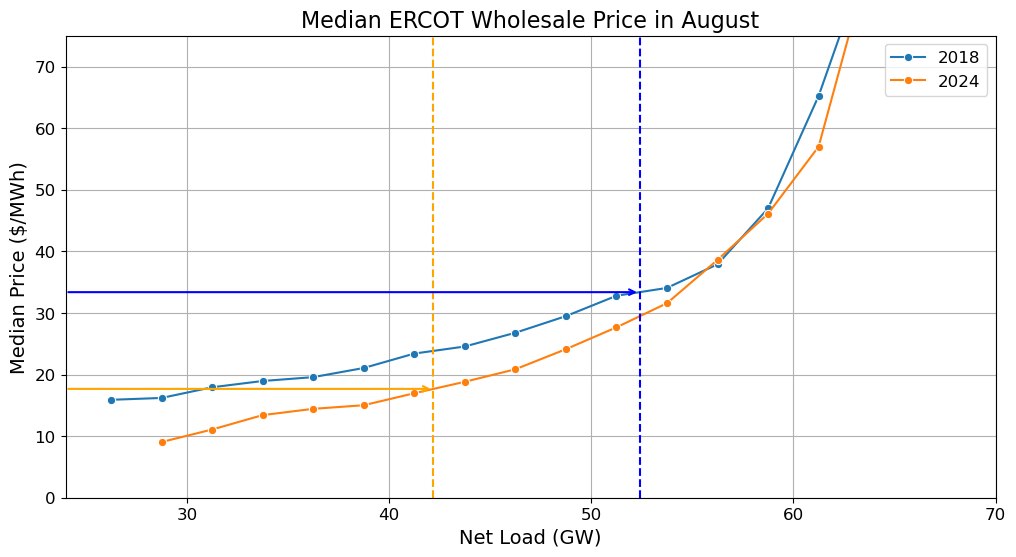

In [ ]:
# Define the bin edges based on the range of net_load across all years
all_net_load = pd.concat([df['net_load'] for df in august_dataframes.values()])
min_net_load = all_net_load.min()
max_net_load = all_net_load.max()
bin_width = 2500
bins = np.arange(min_net_load - (min_net_load % bin_width), max_net_load + bin_width, bin_width)

plt.figure(figsize=(12, 6))

years = ['2018', '2024']

for year in years:
    df = august_dataframes[year].copy() # Use a copy to avoid modifying the original dataframe

    # Create bins for net_load and calculate the median spp for each bin
    df['net_load_bin'] = pd.cut(df['net_load'], bins=bins, right=False)
    median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()

    # Get the midpoint of each bin for plotting
    median_spp_by_bin['net_load_midpoint'] = median_spp_by_bin['net_load_bin'].apply(lambda x: x.mid/1e3)

    # Plot the median spp against the net load bin midpoints
    sns.lineplot(data=median_spp_by_bin, x='net_load_midpoint', y='price', marker='o', label=f'{year}')
    # Create interpolation function to get prices at specific net load values
    interp_func = interp1d(median_spp_by_bin['net_load_midpoint'], 
                          median_spp_by_bin['price'], 
                          kind='linear', fill_value='extrapolate')
    if year == '2018': price_at_52_4 = interp_func(52.4)
    if year == '2024': price_at_42_2 = interp_func(42.2)
# Get prices at specified net load values for annotations
x_min, x_max = plt.xlim()
plt.annotate('', xy=(52.4, price_at_52_4), xytext=(x_min, price_at_52_4),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
plt.annotate('', xy=(42.2, price_at_42_2), xytext=(x_min, price_at_42_2),
            arrowprops=dict(arrowstyle='->', color='orange', lw=1.5))
axvline(x=52.4, color='blue', linestyle='--')
axvline(x=42.2, color='orange', linestyle='--')

plt.title('Median ERCOT Wholesale Price in August', fontsize=16)
plt.xlabel('Net Load (GW)', fontsize=14)
plt.ylabel('Median Price ($/MWh)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.ylim(0,75)
plt.xlim(x_min, 70)
plt.savefig('ercot_price_vs_net_load_august.png', dpi=300)
plt.show()